# Q-learning

```{math}
\DeclareMathOperator*{\argmax}{arg\,max}
\newcommand{\E}{{\mathrm E}}
\newcommand{\underE}[2]{\underset{\begin{subarray}{c}#1 \end{subarray}}{\E}\left[ #2 \right]}
\newcommand{\Epi}[1]{\underset{\begin{subarray}{c}\tau \sim \pi \end{subarray}}{\E}\left[ #1 \right]}
```

## これまでのまとめ

これまで，モンテカルロ法による価値推定手法/ベルマン方程式を基にした価値関数の求解/ベルマン最適方程式を基にした最適方策の求解(価値反復/方策反復)，などを扱ってきました．

まず，モンテカルロ法に関して，本書で紹介した手法は価値推定のみですが，これを方策反復などと組み合わせることにより，最適方策を推定する手法を導くことも出来ます．
モンテカルロ法をもとにした手法の大きな特徴は，環境の情報を必要としないことです．
ベルマン方程式を基にした手法では状態遷移関数$p(s'|s,a)$や報酬関数$r(s,a)$などの情報が必要だったのに対して，モンテカルロ法はエージェントがサンプルした経験のみを必要とします．
しかし，この手法は，値を更新するために最低でもエピソード 1 つ分の経験を必要とします．
つまり，エピソード長が長い/無限に続くタスクに対しては適さない手法です．
また，モンテカルロ法は推定バイアスは無いものの，推定の分散が大きいことが知られています．

そこで本章では，
エージェントがサンプルした経験のみで学習でき，
エピソードが終了せずとも値を更新できる手法 **Q-leraning** を紹介します．

## Q-learning

Q-learning の大きなコンセプトは，

- エージェントが収集した経験をもとに
- ベルマン方程式を解く

というものです．エージェントが収集した経験をもとにするところはモンテカルロ法と共通ですが，ベルマン方程式を解くというコンセプトは価値反復/方策反復と共通です．(Q-learning は特に価値反復と関わりが深い)

まず，Q-learning の大まかな流れは以下のようになります．

```{prf:algorithm} Q-learningの概要
:label: q-learning-concept

**Inputs** $q_0$

**Output** $\mu(s) = \argmax_{a} q(s,a)$

1. 行動価値関数を初期化 $q \leftarrow q_0$

2. while *still time to train*:

    1. 行動$A_t$を*何かしらの方法* で選択．

    2. 行動$A_t$を実行して，経験$(S_t,A_t,S_{t+1},R_t)$を得る．

    3. 経験$(S_t,A_t,S_{t+1},R_t)$をもとに，*何かしらの方法* でベルマン方程式の解に近づくように$q$を更新．


```

```{note}

Q-learningでは価値反復と違い，行動価値関数を推定しています．
価値反復では環境の全ての情報を用いることが出来たため，$V$から$Q$を求めることが出来たのに対し，本手法では環境の情報を用いないことを前提としているため，直接行動価値関数を求める必要があるためです．
行動価値関数も価値関数と同様にベルマン最適作用素$\Upsilon_*$

$$\Upsilon_*(q)(s,a) = r(s,a) + \gamma \sum_{s' \in \mathcal{S}} p(s'|s,a) \max_{a' \in \mathcal{A}} q(s',a') , \forall s \in \mathcal{S}, a \in \mathcal{A}$$

が存在します．これは，価値関数と同様，唯一の不動点が最適行動価値関数$Q^*$となり，作用素を繰り返し適用することにより任意の関数を$Q^*$に漸近的に近づけることが出来ます．

```

このような流れの手法が実現出来れば，上記のコンセプトを満たすことが出来ます．
ここで，このアルゴリズムで考えるべきポイントは以下の2点あります．

1. 経験$(S_t,A_t,S_{t+1},R_t)$から，どうやって$q$を更新するか．
2. 行動$A_t$をどのように選択するのか．

### 行動価値関数の更新

まず，経験$(S_t,A_t,S_{t+1},R_t)$から，どうやって$q$を更新するかを考えます．

環境の完全な情報があれば，$q$は全ての状態/行動に対して，

$$q \leftarrow \Upsilon_*(q) = r(s,a) + \gamma \sum_{s' \in \mathcal{S}} p(s'|s,a) \max_{a' \in \mathcal{A}} q(s',a') , \forall s \in \mathcal{S}, a \in \mathcal{A}$$

と更新すれば良いのですが，Q-learningで使える情報は$(S_t,A_t,S_{t+1},R_t)$のみです．
価値反復では全ての状態行動に対して$q$を更新出来ましたが，$(S_t,A_t,S_{t+1},R_t)$以外の情報が使えないと，
更新できる状態行動は$s = S_t, a = A_t$のときの行動価値$q(S_t, A_t)$のみとなります．
また，$R_t = r(S_t,A_t)$となりますが，$p(s'|S_t,A_t)$がわからないので，以下のように近似します．

$$
\sum_{s' \in \mathcal{S}} p(s'|S_t,A_t) \max_{a' \in \mathcal{A}} q(s',a') \simeq \max_{a' \in \mathcal{A}} q(S_{t+1}, a'), \ S_{t+1} \sim p(\cdot|S_t,A_t)
$$ (q_approx)

これらより，

$$
q(S_t, A_t) &\leftarrow R_t + \gamma \max_{a' \in \mathcal{A}} q(S_{t+1}, a')\\
q(s, a) &\leftarrow q(s, a), \ s \neq S_t, a \neq A_t
$$ (q_update_1)

という更新が考えられますが，これだけだとまだ不十分です．
$q(S_t, A_t)$の更新では式{eq}`q_approx`の近似誤差
$\max_{a' \in \mathcal{A}} q(S_{t+1}, a') - \sum_{s' \in \mathcal{S}} p(s'|S_t,A_t) \max_{a' \in \mathcal{A}} q(s',a') $が存在します．
式{eq}`q_update_1`の更新では，$q$を何度更新し続けても，この誤差の影響で値が振動的になってしまいます．
ここで，時刻$t$までに，ある状態行動対$(s,a)$に対して，qを更新した回数を$n(t,s,a)$とおきます．
式{eq}`q_approx`のような近似を用いると，常にノイズは存在しますが，$n(S_t, A_t)$が十分に大きくなるにつれ，その影響を小さくするように更新することが出来ます．

$$
q(S_t, A_t) &\leftarrow q(S_t, A_t) + \alpha(n(t, S_t, A_t))( R_t + \gamma \max_{a' \in \mathcal{A}} q(S_{t+1}, a') - q(S_t, A_t))\\
q(s, a) &\leftarrow q(s, a), \ s \neq S_t, a \neq A_t
$$ (q_update_2)

ここで$\alpha(x)$はステップサイズと呼ばれ，$x$が大きくなるにつれ，値が適切に減少していく関数です．
一般的に$\alpha(n(t, S_t, A_t)) = \frac{1}{n(t, S_t, A_t)}$などがよく用いられます．

式{eq}`q_update_2`こそがQ-learningにおける$q$の更新方法となります．

(q-learning-convergence)=
```{admonition} Q-learningの収束

本節では，$q$の更新法を直感的に説明しましたが，

$$\sum_{t} \alpha(n(t,s,a)) = \infty, \ \ \sum_{t} \alpha(n(t,s,a)) < \infty, \ \  \forall s \in \mathcal{S}, a \in \mathcal{A}$$

という仮定を満たせば$q$は$Q^*$に収束することが証明されています．
詳しくは[この資料](http://users.isr.ist.utl.pt/~mtjspaan/readingGroup/ProofQlearning.pdf)などを見てみてください．

```

### 行動の選択

つぎに，行動の選択手法を考えていきます．

前節の行動価値関数の更新法から，[Q-learningの収束](q-learning-convergence)の仮定を満たすような行動，つまり全状態行動対に満遍なく訪れるような行動を選択すれば良いのですが，効率よく学習をするためには，以下の2つが重要です．

- **探索(exploration)**
- **活用(exploitation)**

「探索」とは現在の行動価値で敢えて最良とされていない行動を選択することにより，情報量の高い経験を収集することを意味し，
「活用」とは現在の行動価値で最良とされている行動を選択することにより，高い報酬を得られる経験を収集することを意味します．

この２つはバランスが大事です．
例えば「探索」を怠る，つまり，行動が常に現在の$q$の値を最大化するような行動を選択すると，
エージェントが何回行動しても同じ様な経験しか得られず，
全状態行動対に満遍なく訪れることが出来なくなってしまいます．
ただ，Q-learningはローカルサーチ的な側面があるため，
現在最良であると思われる行動を選択することにより得られる経験を多く収集する，
つまり「活用」により得られる経験は学習効率の面で重要です．

そこで，この探索と活用のバランスを取った方策として$\epsilon$-greedy方策というものがあります．
$\epsilon$-greedy方策は，現在の行動価値関数の推定値$q$に対して以下のように行動を選択する方策です．

$$\pi_{\epsilon\text{-greedy}}(a|s;q,\epsilon) = \left\{
\begin{array}{ll}
1-\epsilon + \frac{\epsilon}{|\mathcal{A}|}  & (a = \argmax_{a'} q(s,a')) \\
\frac{\epsilon}{|\mathcal{A}|}  & (それ以外)
\end{array}
\right.$$

この方策は確率$\epsilon$で一様ランダムに行動し，それ以外は最良の行動を選択します．
ここで$\epsilon$はハイパーパラメータで，1に近いと一様ランダムに行動，つまり探索が重視され，0に近いと最良の行動，つまり活用が重視されます．

```{note}

じつは$\epsilon$は定数である必要はなく，時間が経つにつれ小さくするなどといったことも可能です．

```

### まとめ

以上より，{prf:ref}`q-learning-concept`を完全な形にすると，以下のようになります．

```{prf:algorithm} Q-learning
:label: q-learning

**Inputs** $q_0, \epsilon$

**Output** $\mu(s) = \argmax_{a} q(s,a)$

1. 行動価値関数を初期化 $q \leftarrow q_0$
  
    状態$(s,a)$への訪問回数を初期化 $n(s,a) \leftarrow 0$

2. while *still time to train*:

    1. 行動$A_t \sim \pi_{\epsilon\text{-greedy}}(a|s;q,\epsilon)$を選択．

    2. 行動$A_t$を実行して，経験$(S_t,A_t,S_{t+1},R_t)$を得る．

        訪問回数を更新 $n(S_t, A_t) \leftarrow n(S_t, A_t) + 1$

    3. $q$を更新

        $$q(S_t, A_t) &\leftarrow q(S_t, A_t) + \alpha(n(S_t, A_t))( R_t + \gamma \max_{a' \in \mathcal{A}} q(S_{t+1}, a') - q(S_t, A_t))\\
          q(s, a) &\leftarrow q(s, a), \ s \neq S_t, a \neq A_t$$


```


## Q-learningの実装

実際に[FrozenLake](https://www.gymlibrary.ml/environments/toy_text/frozen_lake/)環境に対してQ-learningを適用してみましょう．

In [21]:
import gym

env = gym.make(
    "FrozenLake-v1",
    desc=["SFFF", "FHFH", "FFFH", "HFFG"],
    map_name="4x4",
)


まずは各パラメータを設定し，変数を初期化します．

In [22]:
import numpy as np

# 再現性のためseedを固定
np.random.seed(0)
env.action_space.seed(0)

GAMMA = 0.99  # 割引率
EPSILON = 0.4  # ε-greedy方策のパラメータ
state_size = env.observation_space.n  # 状態数
action_size = env.action_space.n  # 行動数

q = np.zeros((state_size, action_size))  # 行動価値関数の初期値
n = np.zeros((state_size, action_size))


次に$\epsilon$-greedy方策を定義します．

In [23]:
def policy_eps_greedy(s, q, epsilon):
    if np.random.rand() < epsilon:  # 確率εでランダムな行動を選択
        return env.action_space.sample()
    else:  # それ以外では最良の行動を選択
        return np.argmax(q[s, :])


また，現在の$q$に対して最良の行動を選択した場合得られる報酬の期待値をモンテカルロ法でサンプルする関数`check_performance`を実装します．
この関数を学習途中で用いることにより，学習の進捗を確認します．

In [24]:
def check_performance(env, q):
    rewards = []
    for _ in range(50):  # 50エピソード走らせる
        state = env.reset()
        reward_sum = 0.0  # 報酬の合計
        while True:
            action = policy_eps_greedy(state, q, 0.0)  # 最良の行動を選択
            next_state, reward, done, _ = env.step(action)
            reward_sum += reward
            if done:
                rewards.append(reward_sum)
                break
            else:
                state = next_state

    return np.mean(rewards)  # 報酬の平均を求める


以降が，Q-learningの主な実装となります．実装の内容は{prf:ref}`q-learning`とほぼ同じ内容になっています．

ただし，この環境には，終了状態が存在します．そして，終了状態以後は報酬が入らないため，$s$が終了状態だと$Q(s,a) = 0, \forall a \in \mathcal{A}$となります．
シミュレーション環境においては，次の状態`next_state`が終了状態であると，終了状態フラグ`done`が`True(=1)`となるため，$q$の更新式は，

$$q(S_t, A_t) &\leftarrow q(S_t, A_t) + \alpha(n(S_t, A_t))( R_t + \gamma (1 - \text{done}) \max_{a' \in \mathcal{A}} q(S_{t+1}, a') - q(S_t, A_t))\\
  q(s, a) &\leftarrow q(s, a), \ s \neq S_t, a \neq A_t$$

となることに注意してください．


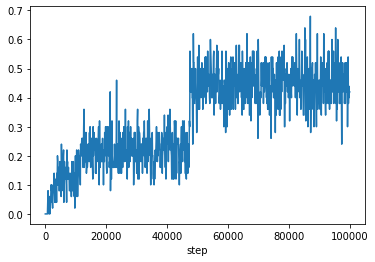

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

performance_log = [] # パフォーマンスのログ

state = env.reset()

for step in range(100000):
    action = policy_eps_greedy(state, q, EPSILON) # 行動を選択
    next_state, reward, done, _ = env.step(action) # 行動を実行，次の状態/報酬/終了判定を得る
    n[state, action] += 1 # 状態行動対への訪問回数
    alpha = 1.0 / n[state, action]  # ステップサイズ
    q[state, action] = q[state, action] + alpha * (
        reward + GAMMA * (1 - done) * np.max(q[next_state, :]) - q[state, action]
    ) # qを更新

    if step % 100 == 0: # 100ステップおきにパフォーマンスを測定
        performance_log.append(check_performance(env, q))

    if done:
        state = env.reset()
    else:
        state = next_state

# ビジュアライズ
plt.plot([i for i in range(0,100000,100)], performance_log)
plt.xlabel("step")
plt.show()
